# Applying XID+CIGALE to Lenses
In this notebook, we read in the data files and prepare them for fitting with XID+CIGALE, the SED prior model extension to XID+. Here we focus on sources Lenses observed by HST and found in Herschel blind catalogues

Import required modules

In [1]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs
import seaborn as sns
import glob


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import os
from ESB_functions import *

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:

emulator_path=['/Users/pdh21/Google_Drive/WORK/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz']
field=['GAMA-12']
path_to_SPIRE=['/Users/pdh21/Work/Astro/Help_HST_sources/notebook_example/']
redshift_file=["/Users/pdh21/Work/Astro/Help_HST_sources/notebook_example/master_catalogue_gama-12_20171210_photoz_20180410_r_optimised.fits"]




In [ ]:

try:
    source = [np.int(os.environ['SGE_TASK_ID'])-1]
except:
    source=[1]

In [3]:
#ysb=Table.read('../../../data/MRRfiles/fromPaper.txt', format='ascii')
esb=Table.read('../HELP_HST_sources_20210625.csv'.format(field[0]),format='csv',encoding='utf-8')


In [4]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [5]:
ind=esb['ID_1_1']==esb[esb['field']==field[0]]['ID_1_1'][source[0]]
c=SkyCoord(esb['RAHMS_1_1'][ind],esb['DECDMS_1_1'][ind],unit=(u.hourangle, u.deg))

In [20]:
c

<SkyCoord (ICRS): (ra, dec) in deg
    [(180.36666667, -2.28)]>

In [21]:
esb[ind]

obs_id_cycle25,obs_id_cycle26,obs_id_cycle19,ID_1_1,ALTERNATE_NAME_1,RAHMS_1_1,DECDMS_1_1,lens_flag_HST,lens_flag_multiwavelength,Ref_lens_flag_multiwavelength
str9,str9,str9,str23,str40,str8,str13,str6,str3,str156
idmh36010,--,--,HATLASJ120127.8-021648,--,12:01:28,-2:16:48,A,C,Negrello et al. 2017


In [22]:
priors,prior_list=process_prior(c,
                path_to_data=['../../../data/'],
                  field=field,
                  path_to_SPIRE=path_to_SPIRE,
                  redshift_file=redshift_file,
                  redshift_prior=[0.1,2.0])
xidplus.save(priors,None,'./output/{}/prior_'.format(field[0])+esb['ID_1_1'][ind].data[0]+'_model1')
prior_list.write('./output/{}/prior_list_'.format(field[0])+esb['ID_1_1'][ind].data[0]+'_model1.ascii',format='ascii',overwrite=True)

fitting 119 sources 

using 875, 494 and 218 pixels
source density = 49099.49994000807


In [23]:
def create_phys_prior(priors,prior_list,emulator_path):
    z_mu=np.empty((priors[1].nsrc))
    z_sig=np.empty((priors[1].nsrc))

    for x,i in enumerate(priors[1].ID):
        
        ind=prior_list['help_id']==str(i)
        z_mu[x]=prior_list['redshift'][ind]
        z_sig[x]=prior_list['redshift_unc'][ind]

    

    sfr_mu=1.5*z_mu+1.0
    sfr_sig=np.full(priors[1].nsrc,0.5)

    agn_frac_mu=np.full(priors[1].nsrc,-1)
    agn_frac_sig=np.full(priors[1].nsrc,1)
    params_mu=np.vstack((sfr_mu,z_mu)).T
    params_sig=np.vstack((sfr_sig,z_sig)).T
    params_names=['log10sfr','z']
    
    return xidplus.hier_prior(priors[1].ID,params_mu,params_sig,params_names,emulator_path[0])

In [24]:
hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}
phys_prior=create_phys_prior(priors,prior_list,emulator_path)

W0604 09:32:21.567369 4580445632 xla_bridge.py:135] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [25]:
from numpyro.infer import Predictive
from jax import random, vmap
from xidplus.numpyro_fit import SED_prior

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [26]:

## For numpyro to sample from the prior, the data needs to be set to None
import copy
#make a deepcopy of the priors
priors_prior_pred=copy.deepcopy(priors)
#set data to None
for i in range(0,len(priors)):
    priors_prior_pred[i].sim=None

In [27]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = {}, num_samples = 1000,)
prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)

CPU times: user 10.8 s, sys: 253 ms, total: 11.1 s
Wall time: 14.3 s


## First pass

In [28]:
import numpyro
from numpyro.diagnostics import summary
import jax.numpy as jnp
from numpyro.infer import NUTS,MCMC
import os
numpyro.set_host_device_count(4)
from operator import attrgetter

def fit_model(phys_prior,hier_params,num_samples=500, num_warmup=500,num_chains=4,chain_method='parallel'):
    nuts_kernel = NUTS(SED_prior.spire_model_CIGALE,init_strategy=numpyro.infer.init_to_feasible())
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup,num_chains=num_chains,chain_method=chain_method)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key,priors,phys_prior,hier_params)
    return mcmc

In [29]:
n_chains=4
mcmc=fit_model(phys_prior,hier_params,num_samples=500, num_warmup=500,num_chains=n_chains,chain_method='parallel')

sample: 100%|██████████| 1000/1000 [01:26<00:00, 11.52it/s, 63 steps of size 5.65e-02. acc. prob=0.86] 


In [30]:
from operator import attrgetter
from numpyro.diagnostics import summary
import jax.numpy as jnp
import os
samples=mcmc.get_samples()
divergences=mcmc.get_extra_fields()['diverging']
prob = 0.9
exclude_deterministic = True
sites = mcmc._states[mcmc._sample_field]
if isinstance(sites, dict) and exclude_deterministic:
    state_sample_field = attrgetter(mcmc._sample_field)(mcmc._last_state)
    # XXX: there might be the case that state.z is not a dictionary but
    # its postprocessed value `sites` is a dictionary.
    # TODO: in general, when both `sites` and `state.z` are dictionaries,
    # they can have different key names, not necessary due to deterministic
    # behavior. We might revise this logic if needed in the future.
    if isinstance(state_sample_field, dict):
        sites = {k: v for k, v in mcmc._states[mcmc._sample_field].items()
                 if k in state_sample_field}

stats_summary = summary(sites, prob=prob)

## Check diagnostics
When running any MCMC algorithm, you need to check that it has explored the full posterior probability space, and not got stuck in local minima. The standard MCMC diagnostics are:
* $\hat{R}$ compares variation within and between chains. You want $\hat{R} < 1.1$
* $n_{eff}$ effective sample size which is a measure of autocorrelation within the chains. More autocorrelation increases uncertainty in estimates. Typical MCMC has a low $n_{eff}$ and requires thinning (as to keep all samples would be too memory intensive). Since NUTS HMC is efficient, there is little need to chuck samples away. If $n_{eff} / N < 0.001$, then there is a problem with model

The other diagnostic, exclusive to The NUTS sampler, is the identification of `divergent transitions`. These identify areas in parameter space where because of some the gradient is very different to the rest of parameter space, such that the tuned NUTS sampler cannot perform its next step accuractely. These tend to occur in funnel like or VERY correlated posterior spaces. Another good explanation can be found [here](https://dev.to/martinmodrak/taming-divergences-in-stan-models-5762). If `divergent transitions` are found, the posterior cannot be trusted and some reparamaterisation is required. Note: Standard MCMC algorithms cannot identify divergent transitions, but that does not mean they do not occur.

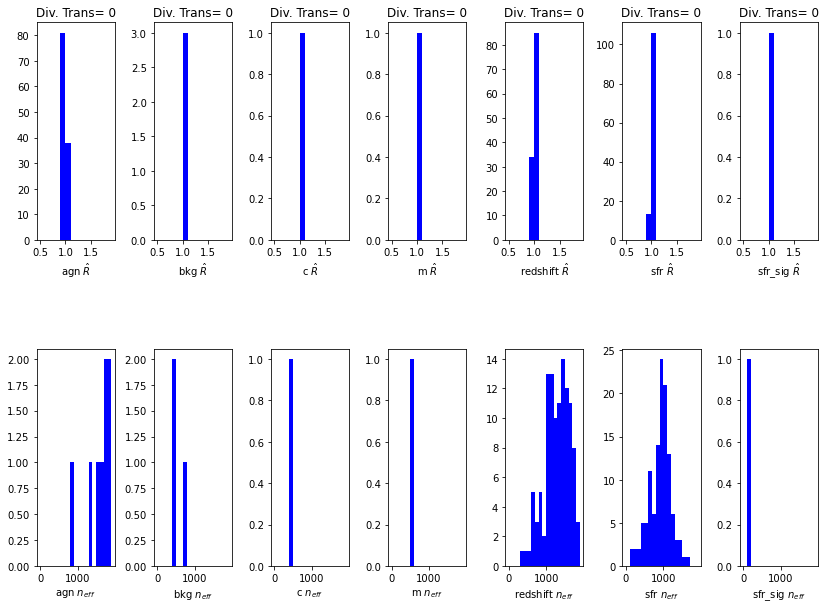

In [31]:
fig,axes=plt.subplots(2,len(samples),figsize=(2*len(samples),10))
for i,k in enumerate(samples):

    axes[0,i].hist(stats_summary[k]['r_hat'].flatten(),color='Blue',bins=np.arange(0.5,2,0.1))
    axes[1,i].hist(stats_summary[k]['n_eff'].flatten(),color='Blue',bins=np.arange(0,samples['m'].shape[0],100))
    axes[0,i].set_xlabel(k+' $ \hat{R}$')
    axes[0,i].set_title('Div. Trans= {}'.format(np.sum(divergences)))
    axes[1,i].set_xlabel(k+' $ n_{eff}$')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

All diagnostics look fine. 

## Posterior Probability distributions

#### Hierarchical parameters

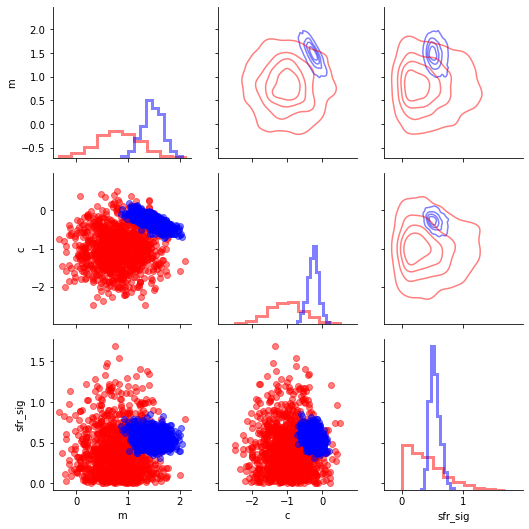

In [32]:
import pandas as pd
hier_param_names=['m','c','sfr_sig']

df_prior=pd.DataFrame(np.array([prior_pred[s] for s in hier_param_names]).T,columns=hier_param_names)
g=sns.PairGrid(df_prior)
g.map_lower(plt.scatter,alpha=0.5,color='Red')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Red',density=True)

df_post=pd.DataFrame(np.array([samples[s] for s in hier_param_names]).T,columns=hier_param_names)
g.data=df_post
g.map_lower(plt.scatter,alpha=0.5,color='Blue')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Blue',density=True)
g.map_upper(sns.kdeplot,alpha=0.5,color='Blue',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#for some reason the contour plots will delete other plots so do last
g.data=df_prior
g.map_upper(sns.kdeplot,alpha=0.5,color='Red',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#### Source parameters 

Text(0, 0.5, 'Redshift')

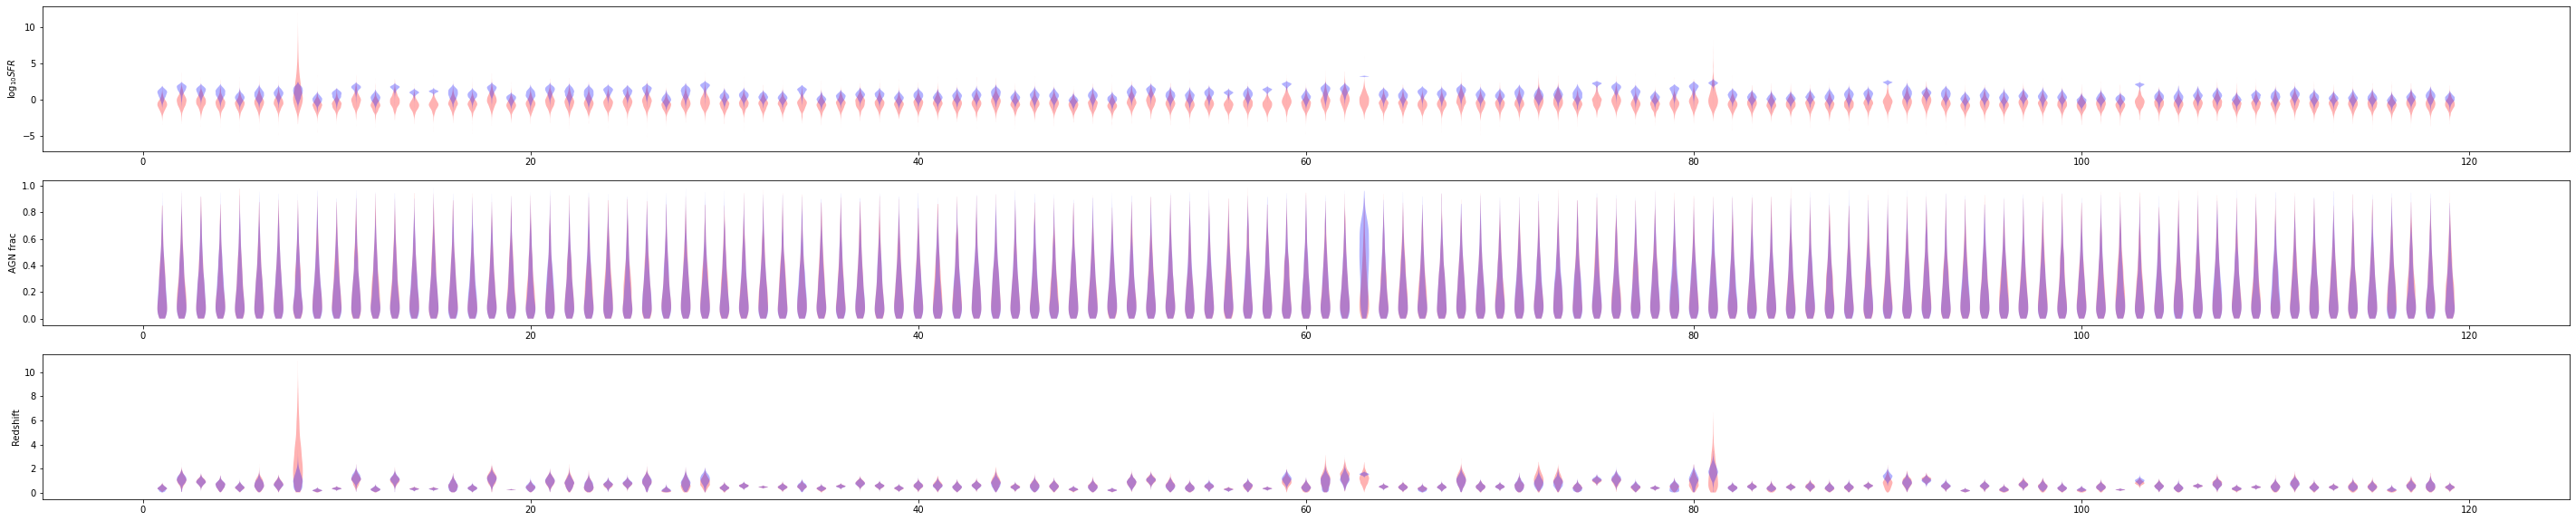

In [33]:
fig,axes=plt.subplots(3,1,figsize=(50,10))
phys_params=['sfr','agn','redshift']
for i ,p in enumerate(phys_params):
    v_plot=axes[i].violinplot(prior_pred[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Red')
    v_plot=axes[i].violinplot(samples[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Blue')

axes[0].set_ylabel('$\log_{10} SFR$')
axes[1].set_ylabel('AGN frac')
axes[2].set_ylabel('Redshift')

### Posterior Predicitive Checks

In [34]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive_samp=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = samples, num_samples = 50)
prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]

CPU times: user 2.76 s, sys: 55.3 ms, total: 2.81 s
Wall time: 2.81 s


In [35]:
#feed the model map arrays the animation function
xidplus.plots.make_map_animation(priors,mod_map_array_samp,50)

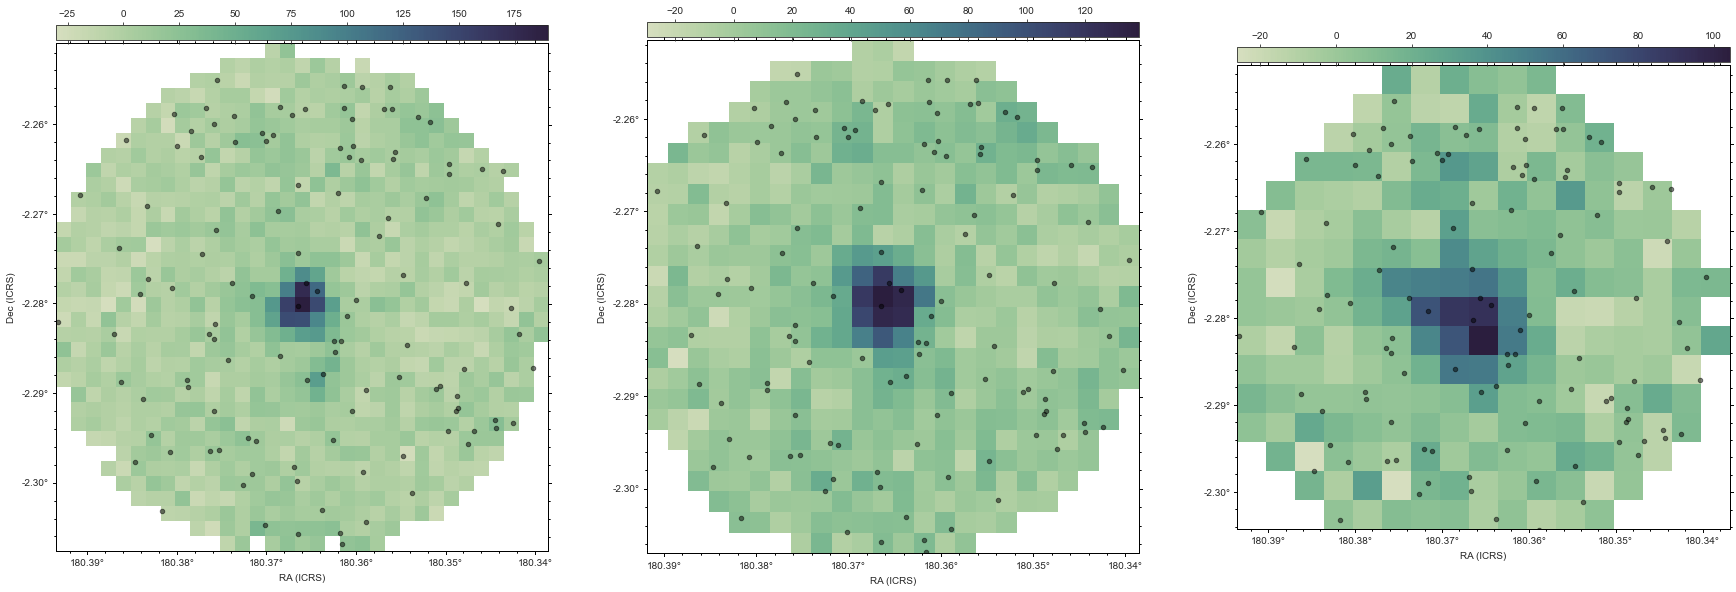

In [36]:
figures,fig=xidplus.plot_map(priors)

## Save the samples using arviz

In [37]:
import arviz as az

In [38]:
numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior_pred,
    posterior_predictive=prior_pred_samp,
    coords={"src": np.arange(0,priors[0].nsrc),
           "band":np.arange(0,3)},
    dims={"agn": ["src"],
         "bkg":["band"],
         "redshift":["src"],
          "sfr":["src"]},
)

In [39]:
numpyro_data.to_netcdf('./output/{}/posterior_'.format(field[0])+esb['ID_1_1'][ind].data[0]+'_model1.nc')

'./output/GAMA-12/posterior_HATLASJ120127.8-021648_model1.nc'

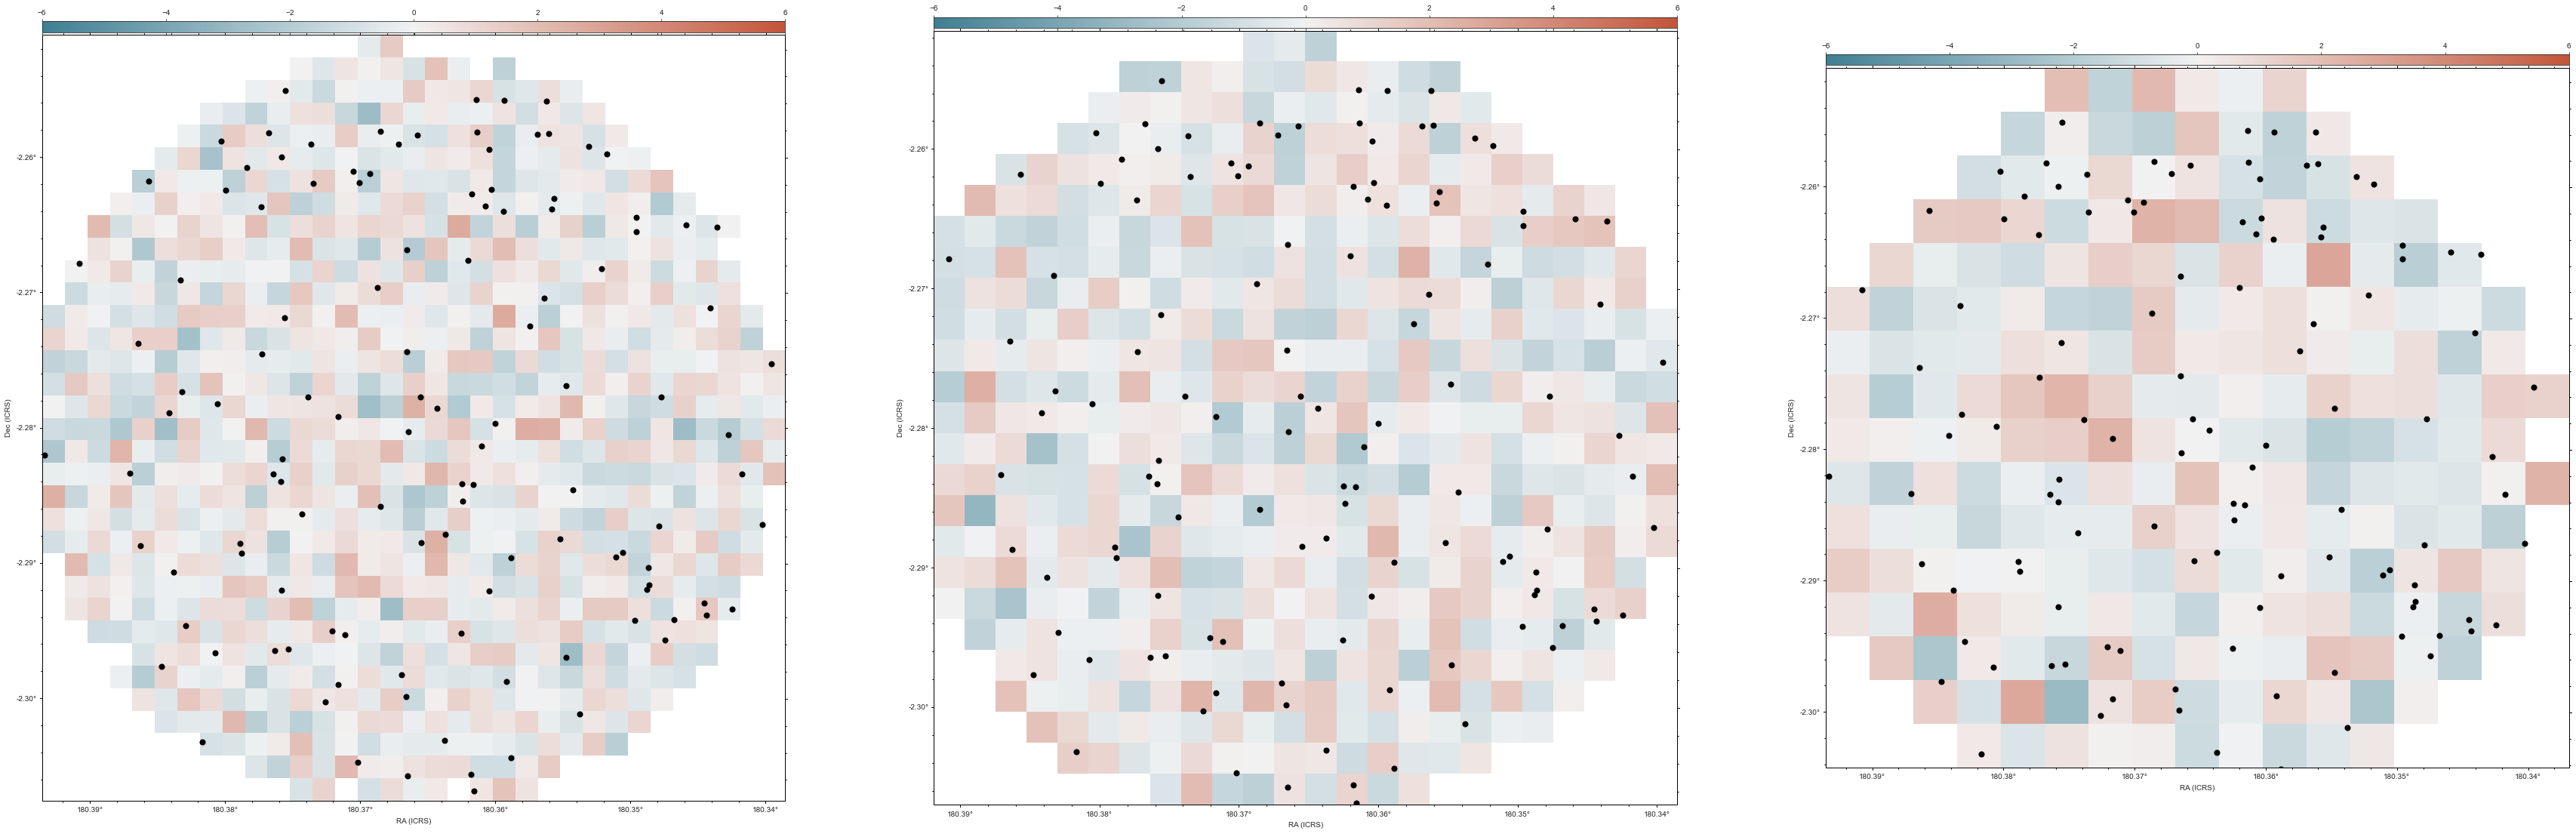

In [40]:
from xidplus import postmaps
import aplpy
sns.set_style("white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
Bayes_pvals = []
hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
fig = plt.figure(figsize=(20 * len(priors), 20))
figs = []
for i in range(0, len(priors)):
    figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
    Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))


for i in range(0, len(priors)):
    figs[i]._data[
        priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
    Bayes_pvals[i]

    
for i in range(0, 3):
    figs[i].show_markers(priors[0].sra, priors[0].sdec, edgecolor='black', facecolor='black',
                         marker='o', s=50, alpha=1.0)
    figs[i].tick_labels.set_xformat('dd.dd')
    figs[i].tick_labels.set_yformat('dd.dd')
    figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
    figs[i].add_colorbar()
    figs[i].colorbar.set_location('top')





In [41]:
sep=20
separation=c.separation(SkyCoord(priors[0].sra,priors[0].sdec)).arcsec
contrib_sources=separation<sep
print(' Sources \n {} \n are possible contributers to flux of extreme starburst'.format(priors[0].ID[contrib_sources]))

 Sources 
           help_id          
---------------------------
HELP_J120127.950-021648.924
HELP_J120129.199-021645.059
HELP_J120127.440-021642.764
HELP_J120127.738-021639.675 
 are possible contributers to flux of extreme starburst


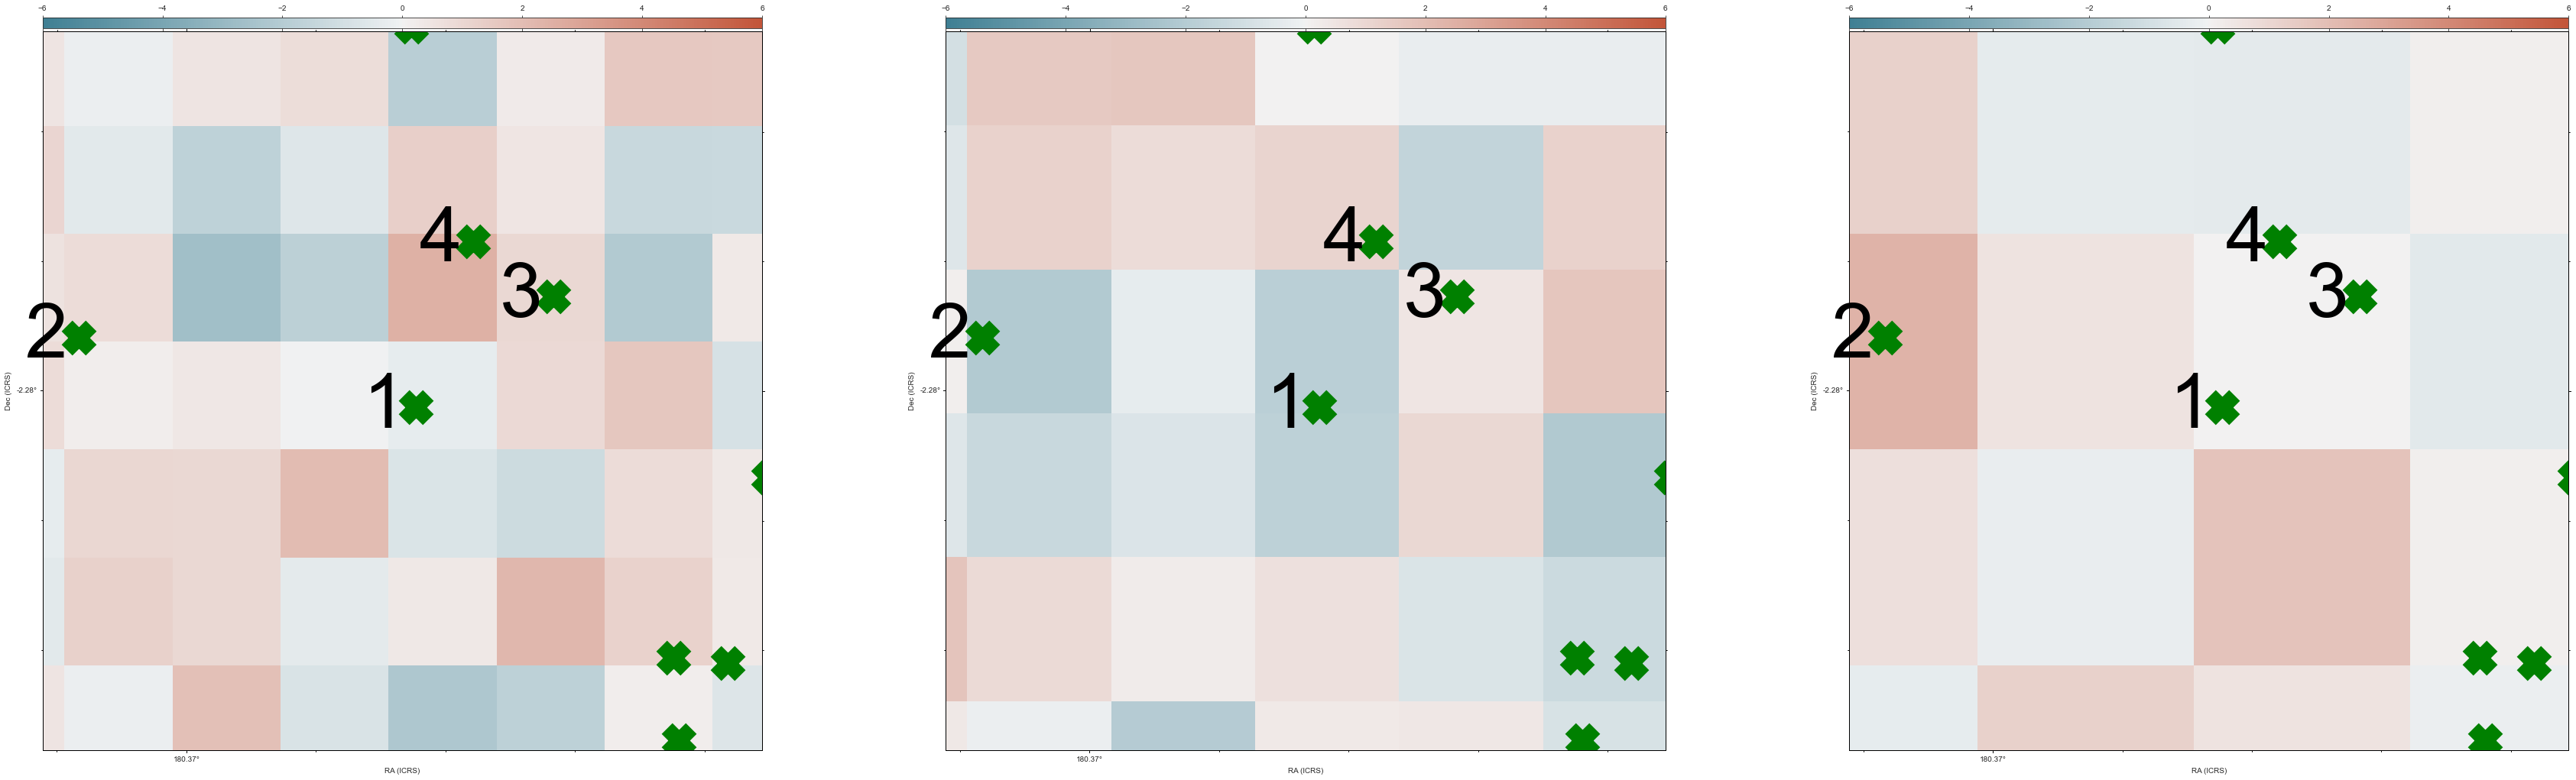

In [44]:
cols=['obs_id_cycle25','obs_id_cycle26','obs_id_cycle19']
blind_pval=['dmu22_XID+SPIRE_psw_GAMA-12_Bayes_Pval.fits','dmu22_XID+SPIRE_pmw_GAMA-12_Bayes_Pval.fits','dmu22_XID+SPIRE_plw_GAMA-12_Bayes_Pval.fits']
standard_pval=['dmu26_XID+SPIRE_psw_GAMA-12_Bayes_Pval_20180508.fits','dmu26_XID+SPIRE_pmw_GAMA-12_Bayes_Pval_20180508.fits','dmu26_XID+SPIRE_plw_GAMA-12_Bayes_Pval_20180508.fits']
from xidplus import postmaps
import aplpy
sns.set_style("white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
Bayes_pvals = []
hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
fig = plt.figure(figsize=(20 * len(priors), 3*20))
figs = []
for i in range(0, len(priors)):
    figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(3, len(priors), i + 1)))
    Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))

#for i in range(0,3):
#    figs.append(aplpy.FITSFigure(blind_pval[i], figure=fig, subplot=(3, len(priors), i + 1+3)))
#for i in range(0,3):
#    figs.append(aplpy.FITSFigure(standard_pval[i], figure=fig, subplot=(3, len(priors), i + 1+6)))
    
for i in range(0, len(priors)):
    figs[i]._data[
        priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
    Bayes_pvals[i]
from astropy.io import ascii, fits

try:
    hst_name=[ i.data.data[0] for i in [esb[i][ind] for i in cols] if np.invert(i.mask[0])][0]
    hst_image=fits.open('../../fits_ast/'+hst_name+'_final_drz_sci_ast.fits')
except (FileNotFoundError, IndexError):
    hst_image=None
    
for i in range(0, 3):
    figs[i].show_markers(priors[0].sra, priors[0].sdec, edgecolor='green', facecolor='green',
                         marker='x', s=1000, alpha=1.0,linewidths=20)
    figs[i].tick_labels.set_xformat('dd.dd')
    figs[i].tick_labels.set_yformat('dd.dd')
    figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
    figs[i].add_colorbar()
    figs[i].colorbar.set_location('top')
    if hst_image is not None:
        figs[i].show_contour(hst_image,colors='black',levels=[25,60,80,100,200])


    #figs[i].show_contour(hst_image,alpha=0.5,cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),stretch='log',vmin=1,vmax=10000)
    figs[i].recenter(c.ra.to_value(),c.dec.to_value(),radius=20.0*1.0/3600.0)
    for z in range(0,contrib_sources.sum()):
        figs[i].add_label(priors[0].sra[contrib_sources][z]+0.0005,priors[0].sdec[contrib_sources][z],str(z+1),size=100)

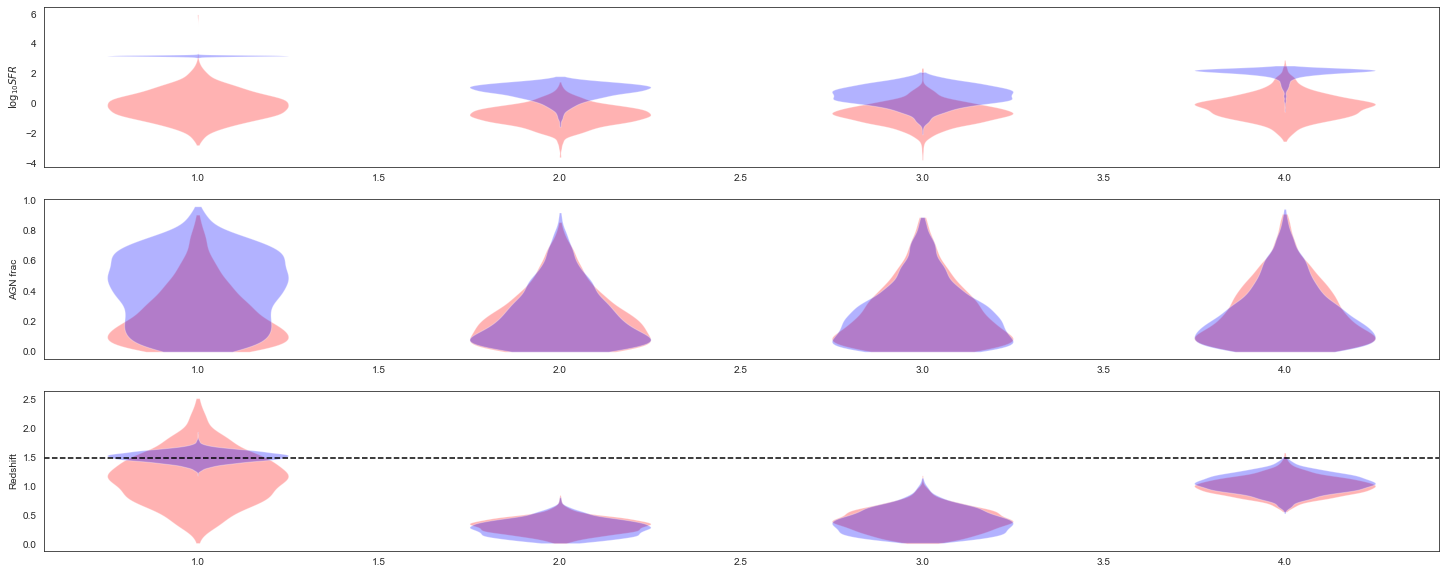

In [45]:
fig,axes=plt.subplots(3,1,figsize=(25,10))
phys_params=['sfr','agn','redshift']
for i ,p in enumerate(phys_params):
    v_plot=axes[i].violinplot(prior_pred[p][:,contrib_sources].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Red')
    v_plot=axes[i].violinplot(samples[p][:,contrib_sources].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Blue')

axes[0].set_ylabel('$\log_{10} SFR$')
axes[1].set_ylabel('AGN frac')
axes[2].set_ylabel('Redshift')

axes[2].axhline(y=1.5,linestyle='--',color='black')

The violinplot shows the posterior distribution for the SFR, AGN frac and redshift for each of the contributing sources. As you can see source no 1 and 4 are the most interesting in that the SFRs are well constrained. 
* no. 1 has a very high, well constrained SFR and the redshift is reasonablly well constrained compared to the uninformative prior
* no. 4 also has a high SFR and slightly higher redshift, but one which is consistent with the prior



## Decide co-ordinates that require a new source
By averaging the P value maps together ( via reprojecting to same resolution) we can find the co-ordinates where the model would suggest new sources need to be added.

In [ ]:
fits_images=[postmaps.make_fits_image(priors[i],postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i])) for i in range(0,3)]



In [ ]:
def Bayes_pval_sources(fits_images):
    #reproject
    from reproject import reproject_interp
    array350, footprint350 = reproject_interp(fits_images[1][1], fits_images[0][1].header,order=0)
    array500, footprint500 = reproject_interp(fits_images[2][1], fits_images[0][1].header,order=0)
    
    # get xx and yy
    xx,yy=np.meshgrid(np.arange(0,array350.shape[1]),np.arange(0,array350.shape[0]))
    #get average zscore
    combined_pval_map=(fits_images[0][1].data+array350+array500)/3.0
    ind=combined_pval_map>2


    from sklearn.cluster import DBSCAN
    X=np.vstack((xx[ind],yy[ind])).T
    
    # Compute DBSCAN
    db = DBSCAN(eps=2, min_samples=2).fit(X)
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    from astropy.table import QTable
    from astropy.wcs import WCS

    w=WCS(fits_images[0][1].header)
    pix_coords=np.asarray([[np.mean(xx[ind][labels==i]),np.mean(yy[ind][labels==i])] for i in range(0,n_clusters_)])
   
    coords_new=w.pixel_to_world(pix_coords[:,0],pix_coords[:,1])
    t=QTable()
    t['ra']=coords_new.ra
    t['dec']=coords_new.dec
    return t

In [ ]:
t=Bayes_pval_sources(fits_images)

In [ ]:
t

In [ ]:
from xidplus import postmaps
import aplpy
sns.set_style("white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
Bayes_pvals = []
hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
fig = plt.figure(figsize=(20 * len(priors), 20))
figs = []
for i in range(0, len(priors)):
    figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
    Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))


for i in range(0, len(priors)):
    figs[i]._data[
        priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
    Bayes_pvals[i]

    
for i in range(0, 3):
    figs[i].show_markers(priors[0].sra, priors[0].sdec, edgecolor='black', facecolor='black',
                         marker='o', s=50, alpha=1.0)
    figs[i].tick_labels.set_xformat('dd.dd')
    figs[i].tick_labels.set_yformat('dd.dd')
    figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
    figs[i].add_colorbar()
    figs[i].colorbar.set_location('top')
    figs[i].show_markers(t['ra'],t['dec'], edgecolor='green', facecolor='green',
                         marker='o', s=50, alpha=1.0)



Having decided where we need to add sources, we will reconstruct the prior list by adding the nearest source in the masterlist to each new position. We will then refit

In [ ]:

if len(t)>0:
    priors,prior_list=process_prior(c,new_Table=t,
                    path_to_data=['../../../data/'],
                      field=field,
                      path_to_SPIRE=path_to_SPIRE,
                      redshift_file=redshift_file,
                      redshift_prior=[0.1,2.0],radius=10)
   
    xidplus.save(priors,None,'./output/{}/prior_'.format(field[0])+esb['ID_1_1'][ind].data[0]+'_model2')
    prior_list.write('./output/{}/prior_list_'.format(field[0])+esb['ID_1_1'][ind].data[0]+'_model2.ascii',format='ascii',overwrite=True)
    hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}
    phys_prior=create_phys_prior(priors,prior_list,emulator_path)
    mcmc=fit_model(phys_prior,hier_params,num_samples=500, num_warmup=500,num_chains=n_chains,chain_method='parallel')

    ## For numpyro to sample from the prior, the data needs to be set to None
    import copy
    #make a deepcopy of the priors
    priors_prior_pred=copy.deepcopy(priors)
    #set data to None
    for i in range(0,len(priors)):
        priors_prior_pred[i].sim=None
    #sample from the prior using numpyro's Predictive function
    prior_predictive=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = {}, num_samples = 1000,)
    prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
    
    #sample from the prior using numpyro's Predictive function
    prior_predictive_samp=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = mcmc.get_samples(), num_samples = 50)
    prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
    mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]
    samples=mcmc.get_samples()
    divergences=mcmc.get_extra_fields()['diverging']
    numpyro_data = az.from_numpyro(
        mcmc,
        prior=prior_pred,
        posterior_predictive=prior_pred_samp,
        coords={"src": np.arange(0,priors[0].nsrc),
               "band":np.arange(0,3)},
        dims={"agn": ["src"],
             "bkg":["band"],
             "redshift":["src"],
              "sfr":["src"]},
        )
    numpyro_data.to_netcdf('./output/{}/posterior_'.format(field[0])+esb['ID_1_1'][ind].data[0]+'_model2.nc')    
    from xidplus import postmaps
    import aplpy
    sns.set_style("white")
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    Bayes_pvals = []
    hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
    fig = plt.figure(figsize=(10 * len(priors), 10))
    figs = []
    for i in range(0, len(priors)):
        figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
        Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))


    for i in range(0, len(priors)):
        figs[i].show_markers(priors[i].sra, priors[i].sdec, edgecolor='black', facecolor='black',
                             marker='o', s=20, alpha=0.5)
        figs[i].tick_labels.set_xformat('dd.dd')
        figs[i].tick_labels.set_yformat('dd.dd')
        figs[i]._data[
            priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
        Bayes_pvals[i]
        figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
        figs[i].add_colorbar()
        figs[i].colorbar.set_location('top')

Fit looks better, source that was missing in top right is now modelled. Issues still remain with area around lens.

In [ ]:
sep=20
separation=c.separation(SkyCoord(priors[0].sra,priors[0].sdec)).arcsec
contrib_sources=separation<sep
print(' Sources \n {} \n are possible contributers to flux of extreme starburst'.format(priors[0].ID[contrib_sources]))

In [ ]:
cols=['obs_id_cycle25','obs_id_cycle26','obs_id_cycle19']
blind_pval=['dmu22_XID+SPIRE_psw_GAMA-12_Bayes_Pval.fits','dmu22_XID+SPIRE_pmw_GAMA-12_Bayes_Pval.fits','dmu22_XID+SPIRE_plw_GAMA-12_Bayes_Pval.fits']
standard_pval=['dmu26_XID+SPIRE_psw_GAMA-12_Bayes_Pval_20180508.fits','dmu26_XID+SPIRE_pmw_GAMA-12_Bayes_Pval_20180508.fits','dmu26_XID+SPIRE_plw_GAMA-12_Bayes_Pval_20180508.fits']
from xidplus import postmaps
import aplpy
sns.set_style("white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
Bayes_pvals = []
hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
fig = plt.figure(figsize=(20 * len(priors), 3*20))
figs = []
for i in range(0, len(priors)):
    figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(3, len(priors), i + 1)))
    Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))

#for i in range(0,3):
#    figs.append(aplpy.FITSFigure(blind_pval[i], figure=fig, subplot=(3, len(priors), i + 1+3)))
#for i in range(0,3):
#    figs.append(aplpy.FITSFigure(standard_pval[i], figure=fig, subplot=(3, len(priors), i + 1+6)))
    
for i in range(0, len(priors)):
    figs[i]._data[
        priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
    Bayes_pvals[i]
from astropy.io import ascii, fits

    
for i in range(0, 3):
    figs[i].show_markers(priors[0].sra, priors[0].sdec, edgecolor='green', facecolor='green',
                         marker='x', s=1000, alpha=1.0,linewidths=20)
    figs[i].tick_labels.set_xformat('dd.dd')
    figs[i].tick_labels.set_yformat('dd.dd')
    figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
    figs[i].add_colorbar()
    figs[i].colorbar.set_location('top')
    if hst_image is not None:
        figs[i].show_contour(hst_image,colors='black',levels=[25,60,80,100,200])


    #figs[i].show_contour(hst_image,alpha=0.5,cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),stretch='log',vmin=1,vmax=10000)
    figs[i].recenter(c.ra.to_value(),c.dec.to_value(),radius=20.0*1.0/3600.0)
    for z in range(0,contrib_sources.sum()):
        figs[i].add_label(priors[0].sra[contrib_sources][z]+0.0005,priors[0].sdec[contrib_sources][z],str(z+1),size=100)

The Bayesian P value maps still hint at requiring other sources, most likely related to the lens

In [ ]:
fig,axes=plt.subplots(3,1,figsize=(25,10))
phys_params=['sfr','agn','redshift']
for i ,p in enumerate(phys_params):
    v_plot=axes[i].violinplot(prior_pred[p][:,contrib_sources].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Red')
    v_plot=axes[i].violinplot(samples[p][:,contrib_sources].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Blue')

axes[0].set_ylabel('$\log_{10} SFR$')
axes[1].set_ylabel('AGN frac')
axes[2].set_ylabel('Redshift')
axes[2].axhline(y=3.259,linestyle='--',color='black')

### Comparing with HELP P value maps
It would be useful to know where the XID+SED should be applied. 

In [46]:
blind_table=Table.read('dmu22_XID+SPIRE_GAMA-12_BLIND_Matched_MF.fits')
xidplus_dr1=Table.read('dmu26_XID+SPIRE_GAMA_12_20180508.fits')

W0604 10:09:36.232459 4580445632 core.py:325] hdu=0 does not contain any data, using hdu=1 instead
W0604 10:09:36.481676 4580445632 core.py:325] hdu=0 does not contain any data, using hdu=1 instead
W0604 10:09:36.694242 4580445632 core.py:325] hdu=0 does not contain any data, using hdu=1 instead
W0604 10:09:36.949095 4580445632 core.py:325] hdu=0 does not contain any data, using hdu=1 instead
W0604 10:09:37.433161 4580445632 core.py:325] hdu=0 does not contain any data, using hdu=1 instead
W0604 10:09:38.246138 4580445632 core.py:325] hdu=0 does not contain any data, using hdu=1 instead


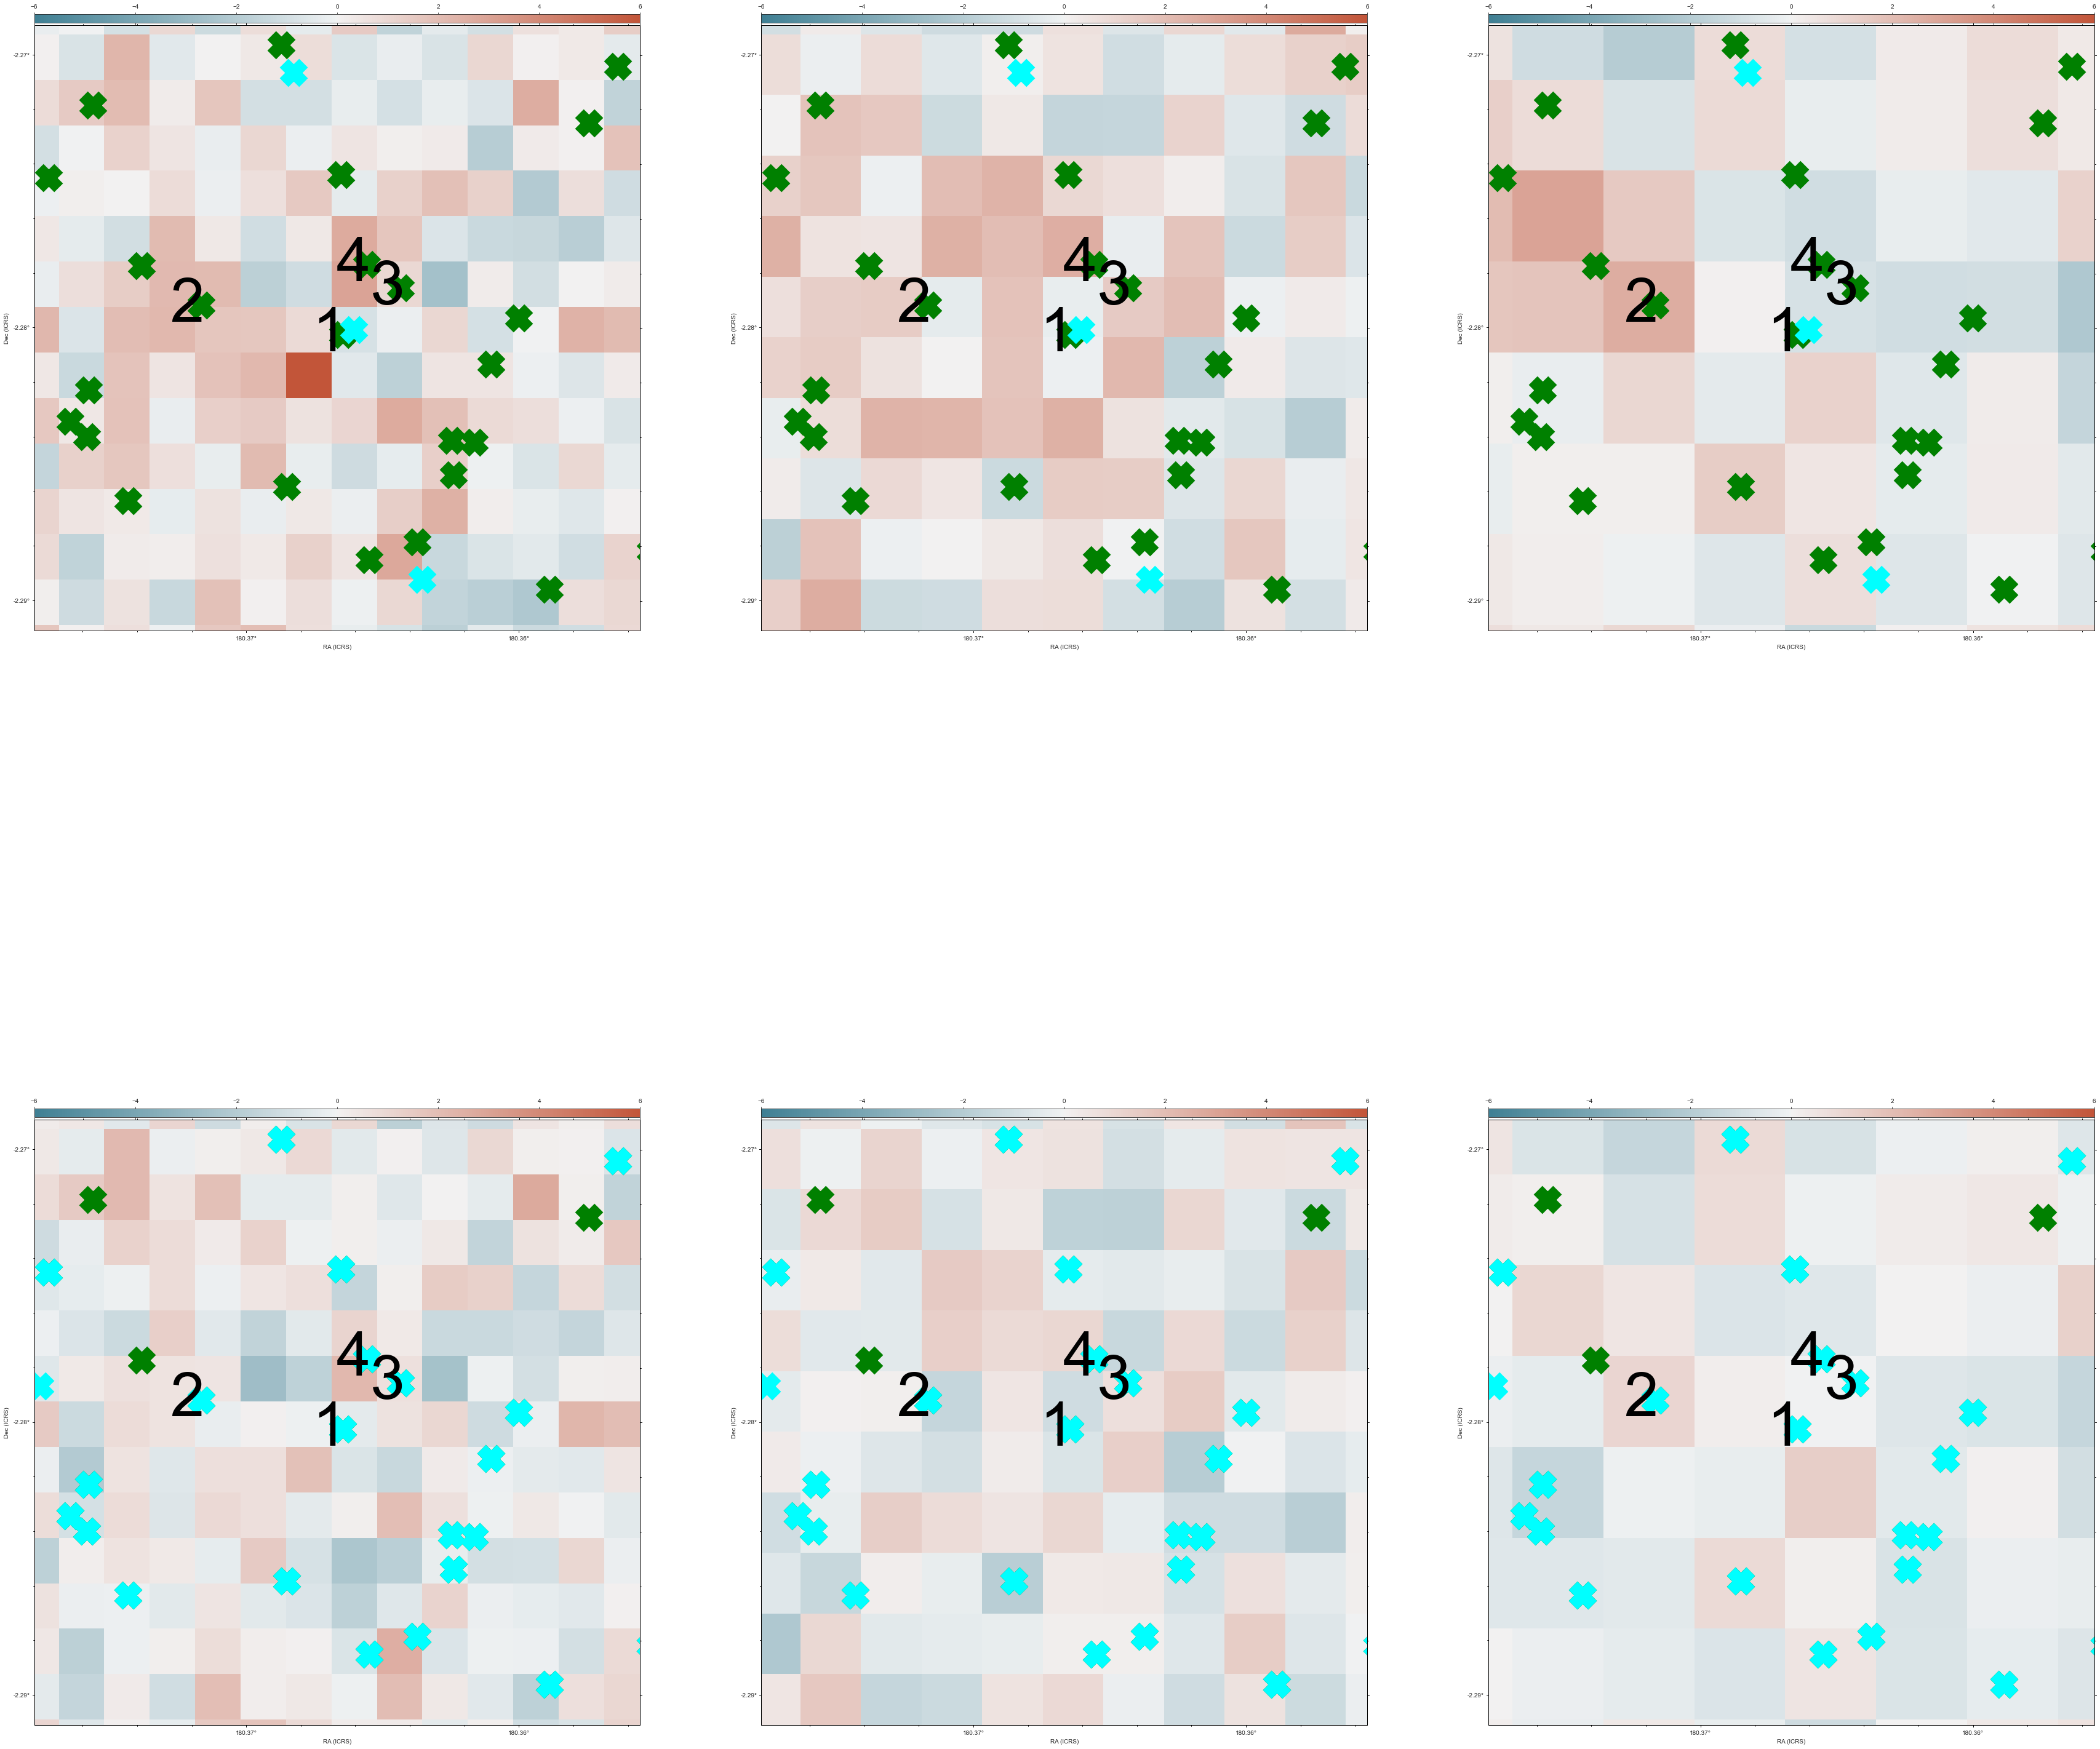

In [47]:
fig = plt.figure(figsize=(20 * len(priors), 3*20))
figs = []
blind_pval=['dmu22_XID+SPIRE_psw_GAMA-12_Bayes_Pval.fits','dmu22_XID+SPIRE_pmw_GAMA-12_Bayes_Pval.fits','dmu22_XID+SPIRE_plw_GAMA-12_Bayes_Pval.fits']
standard_pval=['dmu26_XID+SPIRE_psw_GAMA-12_Bayes_Pval_20180508.fits','dmu26_XID+SPIRE_pmw_GAMA-12_Bayes_Pval_20180508.fits','dmu26_XID+SPIRE_plw_GAMA-12_Bayes_Pval_20180508.fits']

for i in range(0,3):
    figs.append(aplpy.FITSFigure(blind_pval[i], figure=fig, subplot=(2, len(priors), i + 1)))
for i in range(0,3):
    figs.append(aplpy.FITSFigure(standard_pval[i], figure=fig, subplot=(2, len(priors), i + 1+3)))

from astropy.io import ascii, fits

#hst_image=fits.open('../../fits_ast/'+hst_name+'_final_drz_sci_ast.fits')
    
for i in range(0, 6):
    figs[i].show_markers(priors[0].sra, priors[0].sdec, edgecolor='green', facecolor='green',
                         marker='x', s=1000, alpha=1.0,linewidths=20)
    figs[i].tick_labels.set_xformat('dd.dd')
    figs[i].tick_labels.set_yformat('dd.dd')
    figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
    figs[i].add_colorbar()
    figs[i].colorbar.set_location('top')
    if hst_image is not None:
        figs[i].show_contour(hst_image,colors='black',levels=[25,60,80,100,200])



    #figs[i].show_contour(hst_image,alpha=0.5,cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),stretch='log',vmin=1,vmax=10000)
    figs[i].recenter(c.ra.to_value(),c.dec.to_value(),radius=40.0*1.0/3600.0)
    for z in range(0,contrib_sources.sum()):
        figs[i].add_label(priors[0].sra[contrib_sources][z]+0.0005,priors[0].sdec[contrib_sources][z],str(z+1),size=100)
for i in range(0,3):
    figs[i].show_markers(blind_table['RA'],blind_table['Dec'], edgecolor='cyan', facecolor='cyan',
                         marker='x', s=1000, alpha=1.0,linewidths=20)
for i in range(3,6):
    figs[i].show_markers(xidplus_dr1['RA'],xidplus_dr1['Dec'], edgecolor='cyan', facecolor='cyan',
                         marker='x', s=1000, alpha=1.0,linewidths=20)

Top row is blind pvalue map and bottom row is xidplus HELP DR1. There is clearly an issue with both fits suggesting something else is going on. Perhaps this is a way to find interesting sources i.e. look at where both have a problem, and then refit with the xid+SED module.
